In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from keras.models import Sequential
from keras.layers import Dense,Dropout,GRU,SimpleRNN,Input
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.callbacks import EarlyStopping,ModelCheckpoint
from statsmodels.tools.eval_measures import rmse

In [5]:
df=pd.read_csv('Train (1).csv',parse_dates=['date_time'],index_col='date_time')
df.head()

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
date_time,,,,,,,,,,,,,,
2012-10-02 09:00:00,NaN,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,NaN,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,NaN,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,NaN,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,NaN,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33750 entries, 2012-10-02 09:00:00 to 2017-05-17 23:00:00
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   is_holiday           43 non-null     object 
 1   air_pollution_index  33750 non-null  int64  
 2   humidity             33750 non-null  int64  
 3   wind_speed           33750 non-null  int64  
 4   wind_direction       33750 non-null  int64  
 5   visibility_in_miles  33750 non-null  int64  
 6   dew_point            33750 non-null  int64  
 7   temperature          33750 non-null  float64
 8   rain_p_h             33750 non-null  float64
 9   snow_p_h             33750 non-null  float64
 10  clouds_all           33750 non-null  int64  
 11  weather_type         33750 non-null  object 
 12  weather_description  33750 non-null  object 
 13  traffic_volume       33750 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 3.

In [7]:
df.isnull().sum()

is_holiday             33707
air_pollution_index        0
humidity                   0
wind_speed                 0
wind_direction             0
visibility_in_miles        0
dew_point                  0
temperature                0
rain_p_h                   0
snow_p_h                   0
clouds_all                 0
weather_type               0
weather_description        0
traffic_volume             0
dtype: int64

In [8]:
df=df.sort_values(by='date_time')


In [9]:
df['snow_p_h'].unique()

array([0.  , 0.51, 0.32, 0.06, 0.05, 0.21, 0.25, 0.44, 0.13, 0.1 , 0.17,
       0.08])

In [10]:
df.drop(columns=['is_holiday','weather_description'],inplace=True)

In [11]:
df.duplicated().sum()

0

In [12]:
df

,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,traffic_volume
date_time,,,,,,,,,,,,
2012-10-02 09:00:00,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,5545
2012-10-02 10:00:00,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,4516
2012-10-02 11:00:00,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,4767
2012-10-02 12:00:00,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,5026
2012-10-02 13:00:00,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,4918
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-17 21:00:00,74,85,1,328,7,7,287.88,0.0,0.0,90,Mist,2348
2017-05-17 22:00:00,81,70,1,24,2,2,286.95,0.0,0.0,90,Rain,2194
2017-05-17 22:00:00,138,70,1,24,1,1,286.95,0.0,0.0,90,Mist,2194


In [13]:
df=df.resample('M').agg({
    'air_pollution_index':'mean',
    'humidity':'mean',
    'wind_speed':'mean',
    'wind_direction':'mean',
    'visibility_in_miles':'mean',
    'air_pollution_index':'mean',
    'dew_point':'mean',
    'temperature':'mean',
    'rain_p_h':'mean',
    'snow_p_h':'mean',
    'clouds_all':'mean',
    'weather_type':lambda x: x.mode(),
    'traffic_volume':'mean'
})

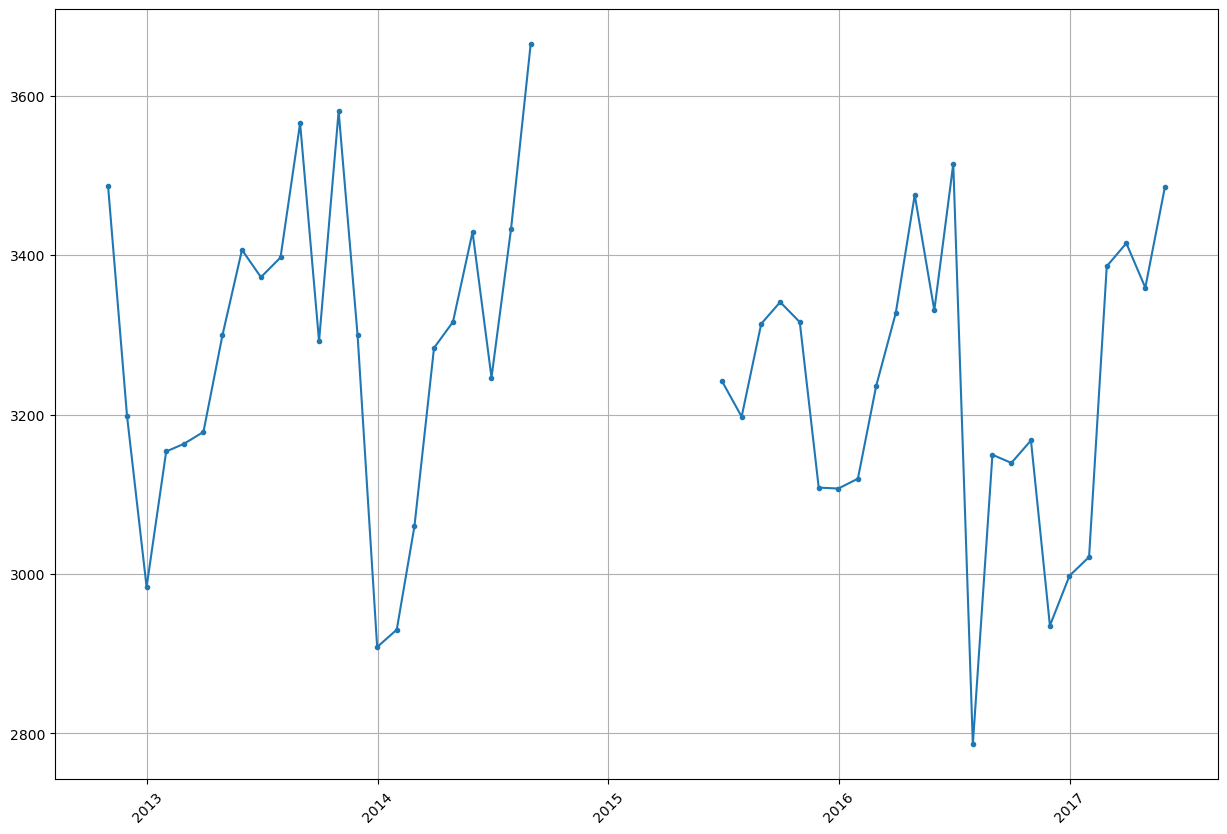

In [14]:
plt.figure(figsize=(15,10))
plt.plot(df.index,df['traffic_volume'],marker='.')
plt.xticks(rotation=45)
plt.grid(True)

In [15]:
df['Day_of_the_week']= df.index.day_of_week
df['Month'] = df.index.month
df['Day_of_the_year'] = df.index.day_of_year
monthly_average = df.groupby('Month')['traffic_volume'].mean()

([<matplotlib.axis.XTick at 0x1d73a76e690>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

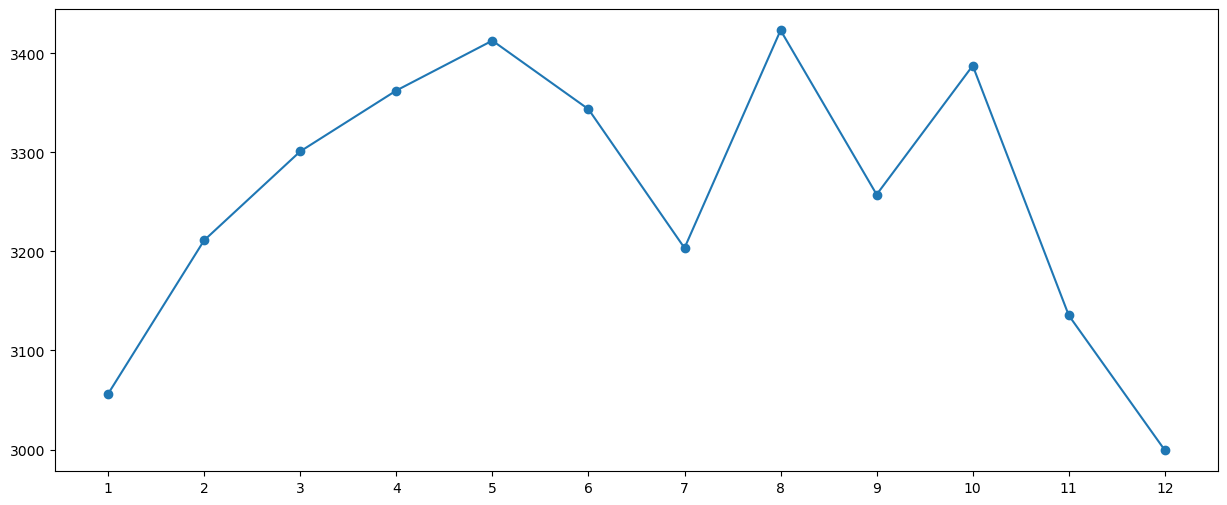

In [16]:
plt.figure(figsize=(15,6))
plt.plot(monthly_average.index,monthly_average.values,marker='o')
plt.xticks(range(1,13))

<Axes: xlabel='date_time'>

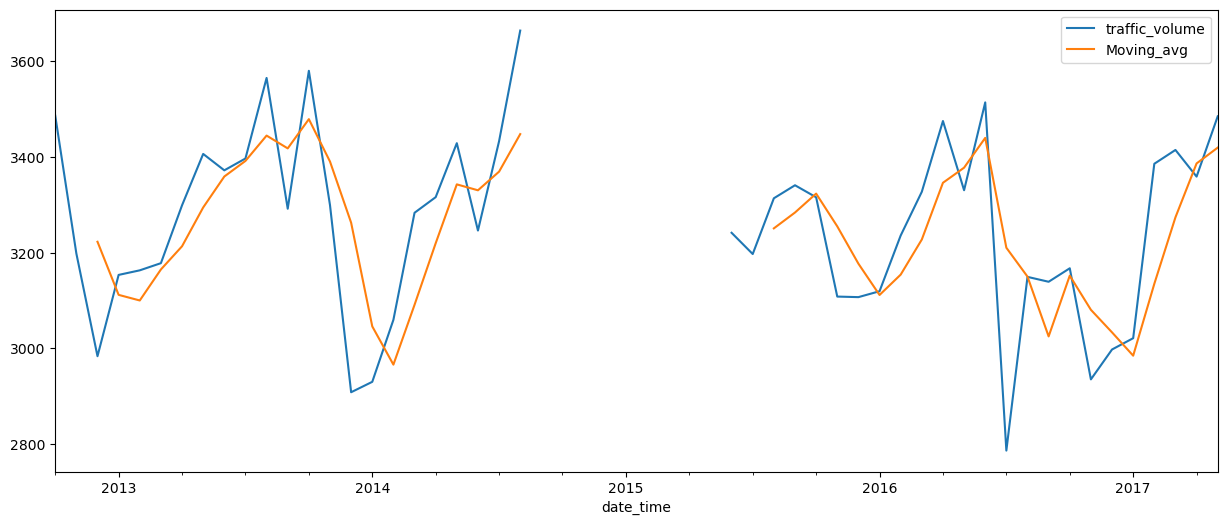

In [17]:
df['Moving_avg']=df['traffic_volume'].rolling(window=3).mean()
df[['traffic_volume','Moving_avg']].plot(figsize=(15,6))

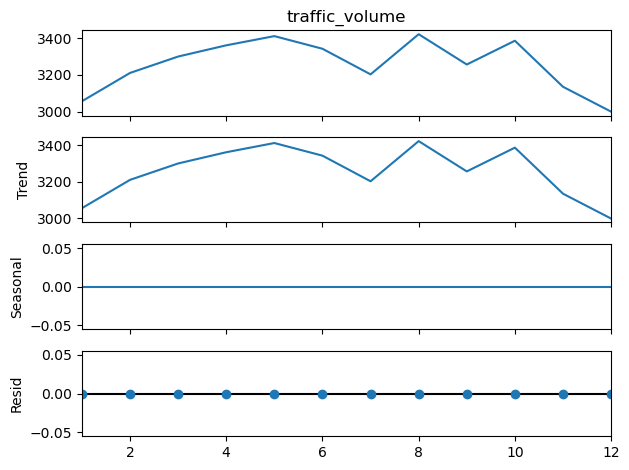

In [18]:
decomposition = seasonal_decompose(x=monthly_average, model='additive',period=1)
decomposition.plot()
plt.show()

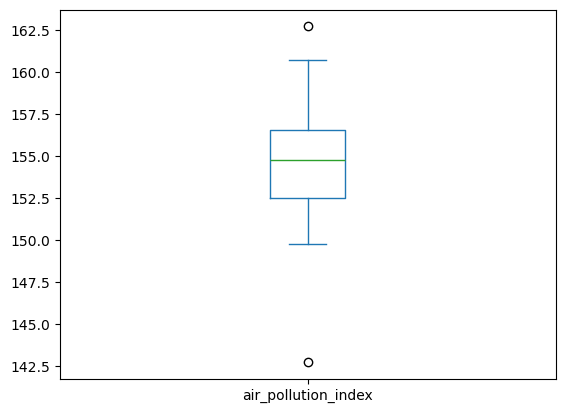

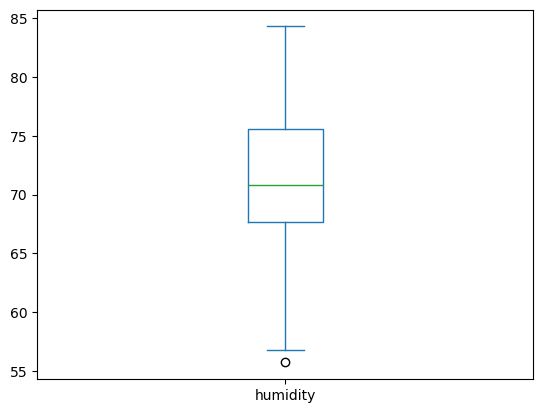

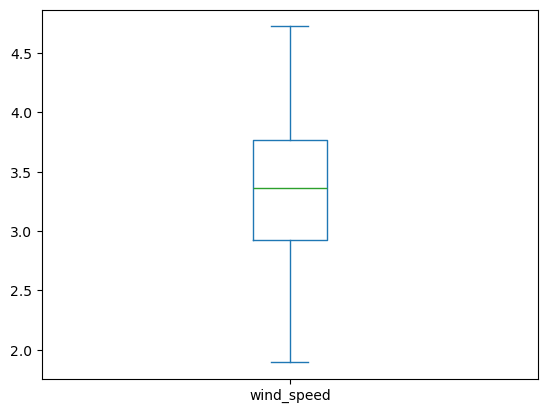

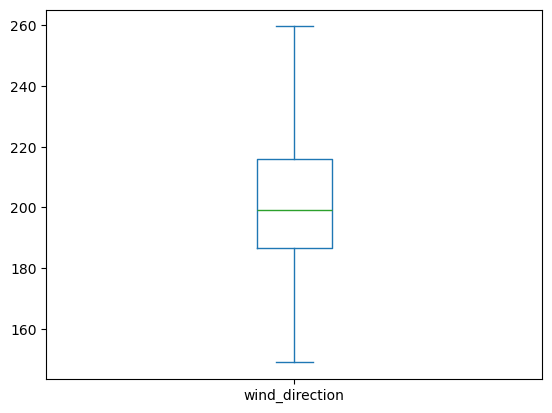

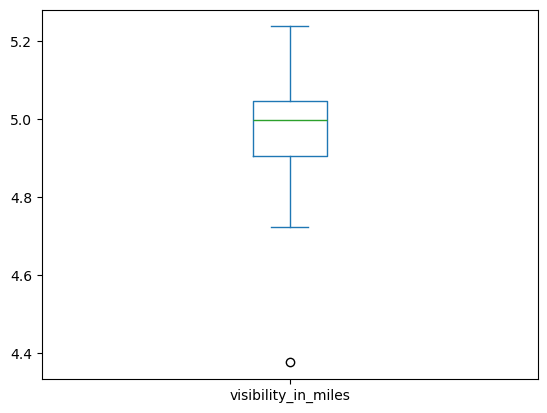

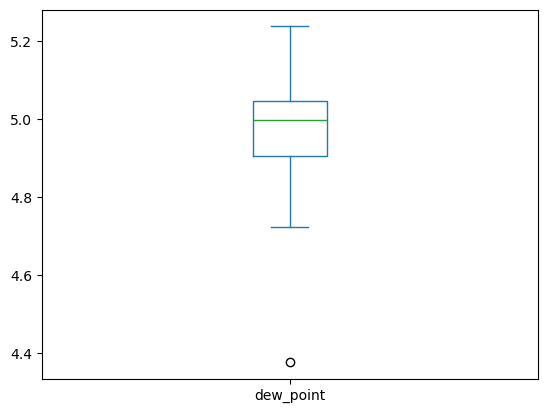

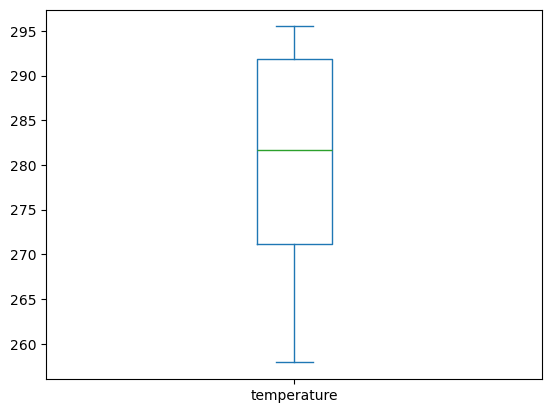

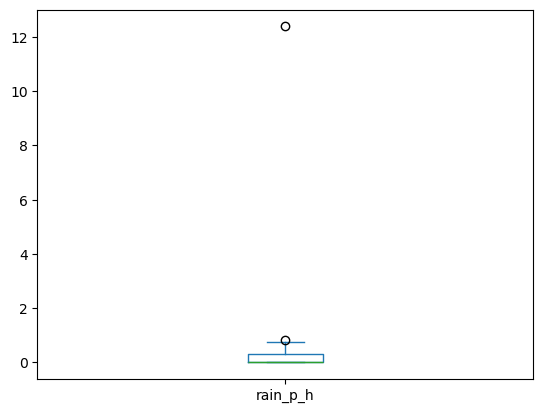

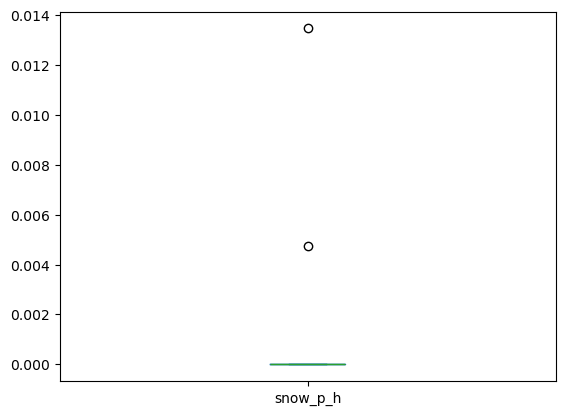

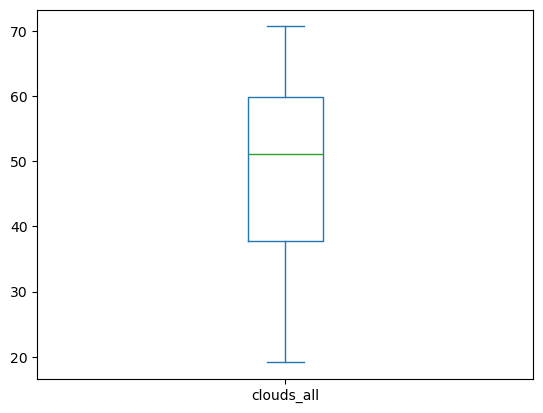

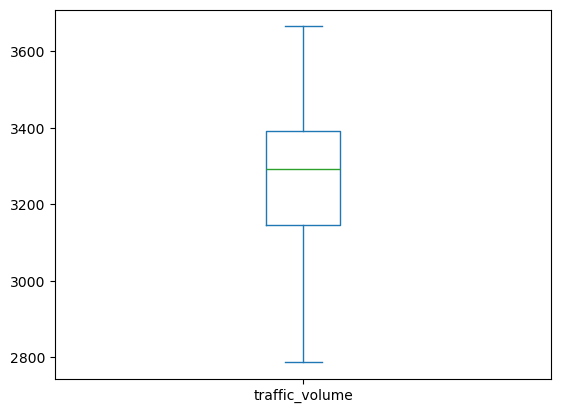

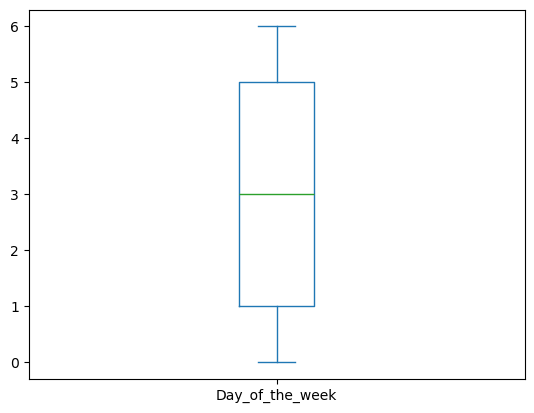

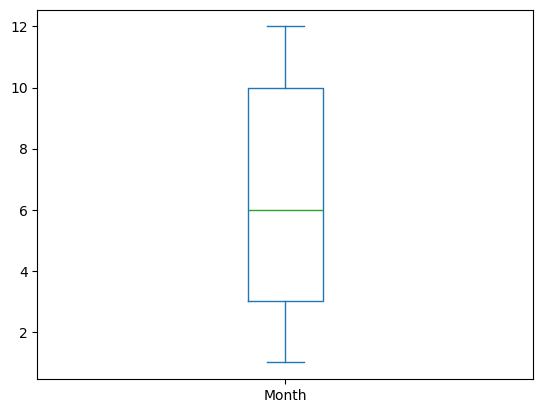

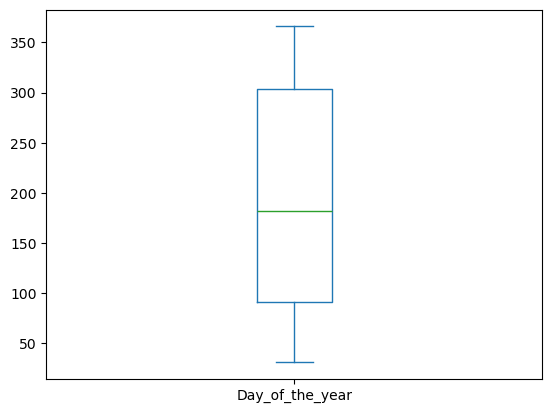

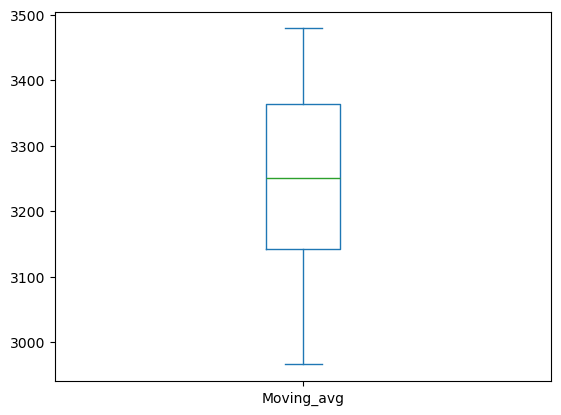

In [19]:
for i in df.select_dtypes('number'):
     df[i].plot(kind='box')
     plt.show()

In [20]:
lags=[]
for i in range(1,6):
    df[f'Lag_{i}']=df['traffic_volume'].shift(i)
    lags.append(f'Lags_{i}')
df

,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,...,traffic_volume,Day_of_the_week,Month,Day_of_the_year,Moving_avg,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
date_time,,,,,,,,,,,,,,,,,,,,,
2012-10-31,155.357764,62.278261,3.362733,190.382609,4.961491,4.961491,281.498907,0.000000,0.000000,64.982609,...,3486.740373,2,10,305,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-30,158.207643,70.369427,3.350318,174.264968,5.109554,5.109554,275.851261,0.000000,0.000000,59.712102,...,3198.431847,4,11,335,NaN,3486.740373,NaN,NaN,NaN,NaN
2012-12-31,152.795666,78.386997,2.997936,188.478844,4.964912,4.964912,268.889690,0.000000,0.000000,70.079463,...,2983.665635,0,12,366,3222.945951,3198.431847,3486.740373,NaN,NaN,NaN
2013-01-31,152.371105,78.371105,3.801700,213.669972,5.082153,5.082153,264.677776,0.000000,0.000000,59.019830,...,3153.654391,3,1,31,3111.917291,2983.665635,3198.431847,3486.740373,NaN,NaN
2013-02-28,150.868898,72.253835,3.291492,167.479777,5.238494,5.238494,265.552357,0.000000,0.000000,69.036262,...,3163.216179,3,2,59,3100.178735,3153.654391,2983.665635,3198.431847,3486.740373,NaN
2013-03-31,152.043357,70.222378,3.351049,172.746853,5.034965,5.034965,270.313077,0.000000,0.000000,53.152448,...,3178.204196,6,3,90,3165.024922,3163.216179,3153.654391,2983.665635,3198.431847,3486.740373
2013-04-30,152.517572,65.034079,3.677316,169.227902,4.996805,4.996805,276.225272,0.000000,0.000000,63.802982,...,3299.192758,1,4,120,3213.537711,3178.204196,3163.216179,3153.654391,2983.665635,3198.431847
2013-05-31,155.022340,75.270213,2.831915,158.086170,5.065957,5.065957,286.407564,0.000000,0.000000,61.317021,...,3406.630851,4,5,151,3294.675935,3299.192758,3178.204196,3163.216179,3153.654391,2983.665635
2013-06-30,155.685789,66.718383,2.671447,199.328553,4.834420,4.834420,291.801617,0.602608,0.000000,50.586701,...,3372.327249,6,6,181,3359.383619,3406.630851,3299.192758,3178.204196,3163.216179,3153.654391


In [21]:
df['Difference between traffic_volume']=df['Day_of_the_week'].diff()


In [22]:
df.dropna(inplace=True)


In [23]:
X=df.drop(columns=['traffic_volume'])
y=df['traffic_volume']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,shuffle=False)



In [24]:
#enc = OneHotEncoder()
#X_train['weather_type']=enc.fit_transform(X_train[['weather_type']])
#X_test['weather_type']=enc.transform(X_test[['weather_type']])

In [25]:
#minmax = MinMaxScaler()
#enc = OneHotEncoder()

#imputer = SimpleImputer(strategy='mean')

#num_pipe = make_pipeline(imputer,minmax)
#cat_pipe = make_pipeline(enc)

#preprossing_pipe = make_column_transformer(
 #   (minmax,['air_pollution_index','humidity','wind_speed','wind_direction','visibility_in_miles','dew_point','temperature','rain_p_h','snow_p_h','clouds_all']),
  #  (cat_pipe,['weather_type']))

#preprossing_pipe

In [26]:
dummitrain=pd.get_dummies(X_train['weather_type'],drop_first=True)
dummitest=pd.get_dummies(X_test['weather_type'],drop_first=True)
dummitrain.astype(int)
dummitest.astype(int)

,Mist,Snow
date_time,,
2016-10-31,0,0
2016-11-30,0,0
2016-12-31,0,1
2017-01-31,1,0
2017-02-28,0,0
2017-03-31,0,0
2017-04-30,0,0
2017-05-31,0,0


In [27]:
Columns_train=dummitrain.columns.values.tolist()
Columns_test=dummitest.columns.values.tolist()

In [28]:
dummitrain.set_index(X_train.index,inplace=True)
dummitest.set_index(X_test.index,inplace=True)
X_train[Columns_train]=dummitrain[Columns_train]
X_test[Columns_test]=dummitest[Columns_test]

In [29]:
#X_train.info()

In [30]:
colum_num=['air_pollution_index','humidity','wind_speed','wind_direction','visibility_in_miles','dew_point','temperature','rain_p_h','snow_p_h','clouds_all']

In [31]:
#scaler=MinMaxScaler()
#scaler.fit(X_train[colum_num])
#X_train=scaler.transform(X_train[colum_num])
#X_test=scaler.transform(X_test[colum_num])

In [32]:
X_train

,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,...,Moving_avg,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Difference between traffic_volume,Clouds,Mist,Rain
date_time,,,,,,,,,,,,,,,,,,,,,
2013-03-31,152.043357,70.222378,3.351049,172.746853,5.034965,5.034965,270.313077,0.000000,0.000000,53.152448,...,3165.024922,3163.216179,3153.654391,2983.665635,3198.431847,3486.740373,3.0,True,False,False
2013-04-30,152.517572,65.034079,3.677316,169.227902,4.996805,4.996805,276.225272,0.000000,0.000000,63.802982,...,3213.537711,3178.204196,3163.216179,3153.654391,2983.665635,3198.431847,-5.0,True,False,False
2013-05-31,155.022340,75.270213,2.831915,158.086170,5.065957,5.065957,286.407564,0.000000,0.000000,61.317021,...,3294.675935,3299.192758,3178.204196,3163.216179,3153.654391,2983.665635,3.0,True,False,False
2013-06-30,155.685789,66.718383,2.671447,199.328553,4.834420,4.834420,291.801617,0.602608,0.000000,50.586701,...,3359.383619,3406.630851,3299.192758,3178.204196,3163.216179,3153.654391,2.0,True,False,False
2013-07-31,155.597594,68.291444,2.560160,199.090909,5.038770,5.038770,295.328019,0.502005,0.000000,27.195187,...,3392.008761,3372.327249,3406.630851,3299.192758,3178.204196,3163.216179,-4.0,False,False,False
2013-08-31,155.313846,72.227692,2.949231,175.478462,5.050769,5.050769,294.483462,0.304369,0.000000,26.980000,...,3444.977451,3397.068182,3372.327249,3406.630851,3299.192758,3178.204196,3.0,False,False,False
2013-09-30,160.713389,74.443515,2.912134,196.910042,4.916318,4.916318,291.183381,0.020586,0.000000,30.972803,...,3418.214951,3565.536923,3397.068182,3372.327249,3406.630851,3299.192758,-5.0,False,False,False
2013-10-31,154.656109,76.572398,3.454751,228.072398,5.004525,5.004525,283.063624,0.266810,0.000000,52.986425,...,3479.333250,3292.039749,3565.536923,3397.068182,3372.327249,3406.630851,3.0,False,False,False
2013-11-30,162.723729,67.344068,2.593220,259.657627,5.045763,5.045763,272.140417,0.019051,0.000000,58.635593,...,3390.685914,3580.423077,3292.039749,3565.536923,3397.068182,3372.327249,2.0,True,False,False


In [33]:
scaled = StandardScaler()
scaled.fit(X_train[colum_num])
X_train = scaled.transform(X_train[colum_num])
X_test = scaled.transform(X_test[colum_num])


In [34]:
X_train

array([[-7.90485713e-01, -3.89212016e-02,  3.50811342e-02,
        -1.18620626e+00,  5.33075844e-01,  5.33075844e-01,
        -9.65474518e-01, -2.70977782e-01, -2.43913360e-01,
         3.33801120e-01],
       [-6.66880093e-01, -1.06804742e+00,  5.02124198e-01,
        -1.32377607e+00,  2.75517873e-01,  2.75517873e-01,
        -4.61853303e-01, -2.70977782e-01, -2.43913360e-01,
         1.15948520e+00],
       [-1.40046885e-02,  9.62343312e-01, -7.08045526e-01,
        -1.75935072e+00,  7.42257154e-01,  7.42257154e-01,
         4.05509615e-01, -2.70977782e-01, -2.43913360e-01,
         9.66760777e-01],
       [ 1.58925109e-01, -7.33956808e-01, -9.37750786e-01,
        -1.47021795e-01, -8.20491330e-01, -8.20491330e-01,
         8.64993718e-01, -1.59630693e-03, -2.43913360e-01,
         1.34891312e-01],
       [ 1.35936766e-01, -4.21932019e-01, -1.09705485e+00,
        -1.56312234e-01,  5.58757574e-01,  5.58757574e-01,
         1.16538486e+00, -4.65681503e-02, -2.43913360e-01,
        -1.

In [35]:
modelGRU=Sequential([
    GRU(units=50,activation='tanh',return_sequences=True,input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    GRU(units=50,activation='tanh',return_sequences=True),
    Dropout(0.2),
    GRU(units=50,activation='tanh',return_sequences=False),

    Dense(units=50,activation='relu'),

    Dense(units=1,activation='relu')
])
modelGRU.summary()

c:\Users\tabt6\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 10, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,151 (160.75 KB)

 Trainable params: 41,151 (160.75 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
modelGRU.compile(optimizer='adam',loss='mse',metrics=['mae'])


In [37]:
Early_Stopping=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
Check_point=ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

In [38]:
History_GRU=modelGRU.fit(X_train,y_train,epochs=2000,validation_split=0.2,callbacks=[Early_Stopping,Check_point])


Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 10828207.0000 - mae: 3285.2346 - val_loss: 10509904.0000 - val_mae: 3232.5574
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 10827976.0000 - mae: 3285.1997 - val_loss: 10509689.0000 - val_mae: 3232.5237
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 10827761.0000 - mae: 3285.1672 - val_loss: 10509456.0000 - val_mae: 3232.4873
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 10827487.0000 - mae: 3285.1252 - val_loss: 10509192.0000 - val_mae: 3232.4465
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 10827215.0000 - mae: 3285.0835 - val_loss: 10508893.0000 - val_mae: 3232.4001
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 10826879.0000 - mae: 3285.0330 - val_loss: 10508559.0000 - val_mae: 3232.3486
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 10826497.0000 - mae: 3284.9751 - val_loss: 10508178.0000 - val_mae: 3232.2903
Epoch 8/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70

In [39]:
hissGRU =  pd.DataFrame(History_GRU.history)

In [40]:
hissGRU

,loss,mae,val_loss,val_mae
0,1.082821e+07,3285.234619,1.050990e+07,3232.557373
1,1.082798e+07,3285.199707,1.050969e+07,3232.523682
2,1.082776e+07,3285.167236,1.050946e+07,3232.487305
3,1.082749e+07,3285.125244,1.050919e+07,3232.446533
4,1.082722e+07,3285.083496,1.050889e+07,3232.400146
...,...,...,...,...
1527,3.804859e+04,157.845978,6.046323e+04,207.557373
1528,3.801591e+04,157.720078,6.046457e+04,207.557419
1529,3.798287e+04,157.592194,6.046607e+04,207.557373
1530,3.795015e+04,157.465027,6.046782e+04,207.557373


<Axes: >

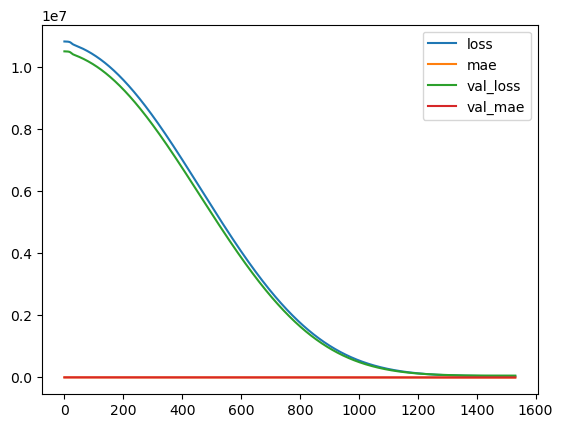

In [41]:
hissGRU.plot()

In [42]:
y_pred = modelGRU.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


<Axes: xlabel='date_time'>

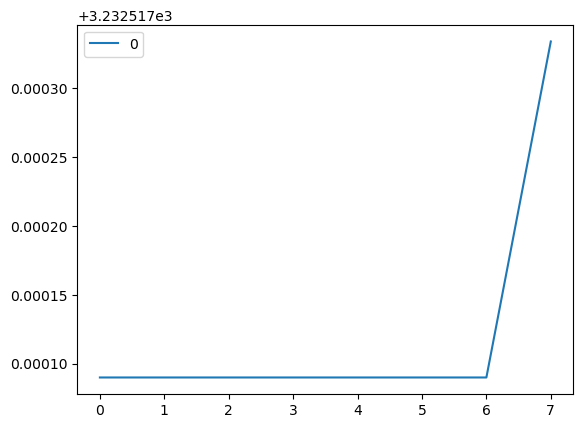

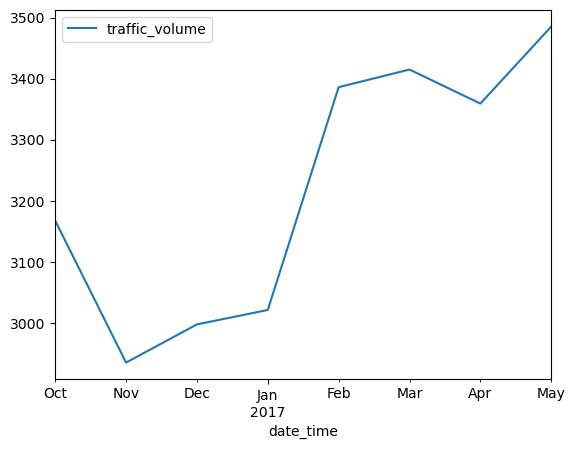

In [43]:
pd.DataFrame(y_pred).plot()
pd.DataFrame(y_test).plot()

In [44]:
from statsmodels.tools.eval_measures import rmse

print(mean_squared_error(y_pred,y_test))
print(rmse(y_pred,y_test))

41141.21743449599
[ 65.00680399 297.31283027 234.80802945 211.19255896 153.52489645
 182.41467155 126.6781029  252.74415783]
